<a href="https://colab.research.google.com/github/shreyasym12004/Audiocrypt/blob/main/SatFrame_Sync.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

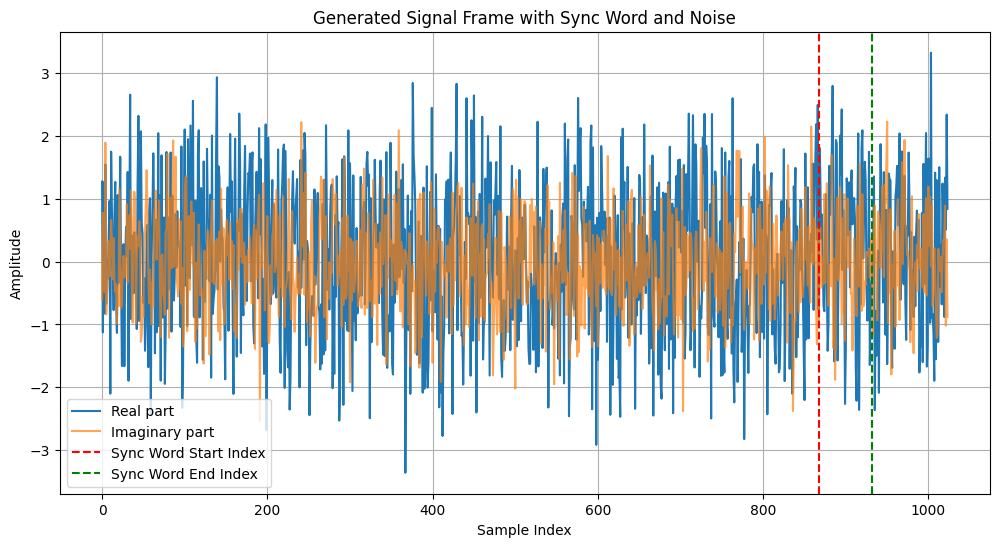

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def generate_frame_data(n_total=1024, sync_word_len=64):
    # 1. Define a fixed Sync Word (Barker Sequence)
    sync_word = np.array([1,1,1,1,1,0,0,1,1,0,1,0,1] * 5)[:sync_word_len] # Repeated Barker
    sync_iq = (sync_word * 2 - 1) + 0j

    # 2. Generate random payload
    payload = np.random.randint(0, 2, n_total - sync_word_len)
    payload_iq = (payload * 2 - 1) + 0j

    # 3. Randomly insert Sync Word
    start_idx = np.random.randint(0, n_total - sync_word_len)
    full_frame = np.concatenate([payload_iq[:start_idx], sync_iq, payload_iq[start_idx:]])

    # 4. Add heavy noise (SNR = -5dB to 5dB)
    snr = np.random.uniform(-5, 5)
    noise = (np.random.randn(n_total) + 1j*np.random.randn(n_total)) * np.sqrt(1/(10**(snr/10)))
    sig = full_frame + noise

    return np.stack((sig.real, sig.imag), axis=1), start_idx

# Y (Label) will be the start_idx

# Generate and plot a sample frame to visualize
sample_frame, sample_start_idx = generate_frame_data()
signal_real = sample_frame[:, 0]
signal_imag = sample_frame[:, 1]

plt.figure(figsize=(12, 6))
plt.plot(signal_real, label='Real part')
plt.plot(signal_imag, label='Imaginary part', alpha=0.7)
plt.title('Generated Signal Frame with Sync Word and Noise')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.axvline(x=sample_start_idx, color='r', linestyle='--', label='Sync Word Start Index')
plt.axvline(x=sample_start_idx + 64, color='g', linestyle='--', label='Sync Word End Index')
plt.legend()
plt.grid(True)
plt.show()

### Generate Training Data
We'll generate a large number of samples using the `generate_frame_data` function and create a `tf.data.Dataset` for efficient training.

### Evaluate Model Performance
Now, let's evaluate the trained model on a new, unseen test dataset to check its generalization capabilities.

In [9]:
# Function to generate data for the test tf.data.Dataset
def test_data_generator():
    while True:
        signal, start_idx = generate_frame_data()
        label = np.zeros(1024, dtype=np.float32)
        label[start_idx:start_idx + 64] = 1.0
        label = label.reshape(1024, 1)
        yield signal.astype(np.float32), label

# Create a TensorFlow Test Dataset
batch_size = 32
test_dataset = tf.data.Dataset.from_generator(
    test_data_generator,
    output_signature=(
        tf.TensorSpec(shape=(1024, 2), dtype=tf.float32),
        tf.TensorSpec(shape=(1024, 1), dtype=tf.float32)
    )
).batch(batch_size).prefetch(tf.data.AUTOTUNE)

print(f"Test Dataset created with batch size: {batch_size}")

# Evaluate the model on the test dataset
print("\nEvaluating model on the test set...")
loss, accuracy = model.evaluate(test_dataset, steps=50) # Evaluate on 50 batches for demonstration

print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


Test Dataset created with batch size: 32

Evaluating model on the test set...
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 270ms/step - accuracy: 0.9928 - loss: 0.0230

Test Loss: 0.0232
Test Accuracy: 0.9925


In [6]:
# Function to generate data for the tf.data.Dataset
def data_generator():
    while True:
        signal, start_idx = generate_frame_data()

        # Create a one-hot like label for the output heatmap
        # The output heatmap should have 1 at the start_idx and 0 elsewhere
        label = np.zeros(1024, dtype=np.float32)
        label[start_idx:start_idx + 64] = 1.0 # Mark the sync word duration
        label = label.reshape(1024, 1)

        yield signal.astype(np.float32), label

# Create a TensorFlow Dataset
batch_size = 32
dataset = tf.data.Dataset.from_generator(
    data_generator,
    output_signature=(
        tf.TensorSpec(shape=(1024, 2), dtype=tf.float32),
        tf.TensorSpec(shape=(1024, 1), dtype=tf.float32)
    )
).batch(batch_size).prefetch(tf.data.AUTOTUNE)

print(f"Dataset created with batch size: {batch_size}")
print("Example output shape:")
for features, labels in dataset.take(1):
    print(f"  Features shape: {features.shape}")
    print(f"  Labels shape: {labels.shape}")

Dataset created with batch size: 32
Example output shape:
  Features shape: (32, 1024, 2)
  Labels shape: (32, 1024, 1)


# Task
```python
import tensorflow as tf
from tensorflow.keras import layers, models

# 1. Define the Keras model
def create_model(input_shape=(1024, 2), output_sequence_length=1024):
    model = models.Sequential([
        # Input layer expects (sequence_length, features)
        layers.Input(shape=input_shape),

        # First Conv1D block
        layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2, padding='same'), # Output shape (512, 64)

        # Second Conv1D block
        layers.Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2, padding='same'), # Output shape (256, 128)

        # Third Conv1D block
        layers.Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2, padding='same'), # Output shape (128, 256)

        # Upsampling / Deconvolution to restore sequence length
        layers.Conv1DTranspose(filters=128, kernel_size=3, activation='relu', padding='same', strides=2), # Output shape (256, 128)
        layers.BatchNormalization(),
        layers.Conv1DTranspose(filters=64, kernel_size=3, activation='relu', padding='same', strides=2), # Output shape (512, 64)
        layers.BatchNormalization(),
        layers.Conv1DTranspose(filters=32, kernel_size=3, activation='relu', padding='same', strides=2), # Output shape (1024, 32)
        layers.BatchNormalization(),

        # Output layer: 1 filter for the heatmap, sigmoid activation for probabilities
        layers.Conv1D(filters=1, kernel_size=1, activation='sigmoid', padding='same') # Output shape (1024, 1)
    ])
    return model

model = create_model()
model.summary()

# 2. Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 3. Train the model
print("\nStarting model training...")
history = model.fit(dataset, epochs=10, steps_per_epoch=100) # Using 100 steps per epoch for demonstration

print("\nModel training completed!")
print("Training History:", history.history)
```

# Sync Word Detection using Deep Learning

## Project Overview
This project aims to detect the start index of a synchronization word (sync word) embedded within a noisy signal using a deep learning approach. The model learns to identify the sync word's location by outputting a heatmap-like probability distribution, indicating the likelihood of the sync word's presence at each time step.

## Data Generation
Synthetic training data is generated to simulate real-world noisy signals. 
- The `generate_frame_data` function creates a signal frame of a fixed length (1024 samples) by embedding a predefined sync word (Barker Sequence) within random payload data. 
- Heavy noise, with SNR ranging from -5dB to 5dB, is added to the signal. 
- The `data_generator` function then formats this data for TensorFlow, creating a label that marks the sync word's duration (64 samples) with 1.0 and other parts with 0.0. 
- This data is then used to construct a `tf.data.Dataset` for efficient batch processing d

## Train Model

### Subtask:
Train the defined Keras model using the `dataset` created in the previous step. We'll train it for 10 epochs for demonstration purposes.


**Reasoning**:
To train the model, I need to first import TensorFlow and Keras layers, then define and create the model, compile it, and finally train it using the `dataset` from the previous step. All these steps can be done in a single code block.



In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models

# 2. Define the create_model function
def create_model(input_shape=(1024, 2), sync_word_len=64):
    model = models.Sequential([
        # Encoder
        layers.Conv1D(filters=32, kernel_size=16, activation='relu', input_shape=input_shape, padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2, padding='same'),

        layers.Conv1D(filters=64, kernel_size=16, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2, padding='same'),

        layers.Conv1D(filters=128, kernel_size=16, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2, padding='same'),

        # Decoder
        layers.Conv1DTranspose(filters=128, kernel_size=16, strides=2, activation='relu', padding='same'),
        layers.BatchNormalization(),

        layers.Conv1DTranspose(filters=64, kernel_size=16, strides=2, activation='relu', padding='same'),
        layers.BatchNormalization(),

        layers.Conv1DTranspose(filters=32, kernel_size=16, strides=2, activation='relu', padding='same'),
        layers.BatchNormalization(),

        # Output layer - output a heatmap of sync word locations
        layers.Conv1D(filters=1, kernel_size=sync_word_len, activation='sigmoid', padding='same')
    ])
    return model

# 3. Create an instance of the model
model = create_model()

# 4. Print the model summary
print("\nModel Summary:")
model.summary()

# 5. Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 6. Print a message indicating the start of model training
print("\nStarting model training...")

# 7. Train the compiled model
history = model.fit(dataset, epochs=10, steps_per_epoch=100)

# 8. Print a message indicating the completion of model training
print("\nModel training completed.")

# 9. Print the training history
print("\nTraining History:")
print(history.history)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Model Summary:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_9 (Conv1D)               │ (None, 1024, 32)       │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 512, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 512, 64)        │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 256, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 256, 128)       │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose                │ (None, 256, 128)       │       262,272 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_1              │ (None, 512, 64)        │       131,136 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_2              │ (None, 1024, 32)       │        32,800 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1024, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 1024, 1)        │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 595,137 (2.27 MB)

 Trainable params: 594,241 (2.27 MB)

 Non-trainable params: 896 (3.50 KB)


Starting model training...
Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.8392 - loss: 0.4018
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 0.9876 - loss: 0.0391
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.9901 - loss: 0.0296
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.9897 - loss: 0.0318
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 0.9920 - loss: 0.0241
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.9926 - loss: 0.0233
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.9927 - loss: 0.0223
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 0.9922 - loss: 0.0240
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.9939 - loss: 0.0189
Epoch 10/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 0.9934 - loss: 0.0194

Model training completed.

Training History:
{'accuracy': [0.9375585913658142, 0.9890661835670471, 0

# Task
Plot the training loss and accuracy over epochs.

## Plot Training History

### Subtask:
Plot the training loss and accuracy over the epochs from the `history` object.


**Reasoning**:
To visualize the model's performance during training, I will plot the loss and accuracy metrics recorded in the `history` object over the epochs.



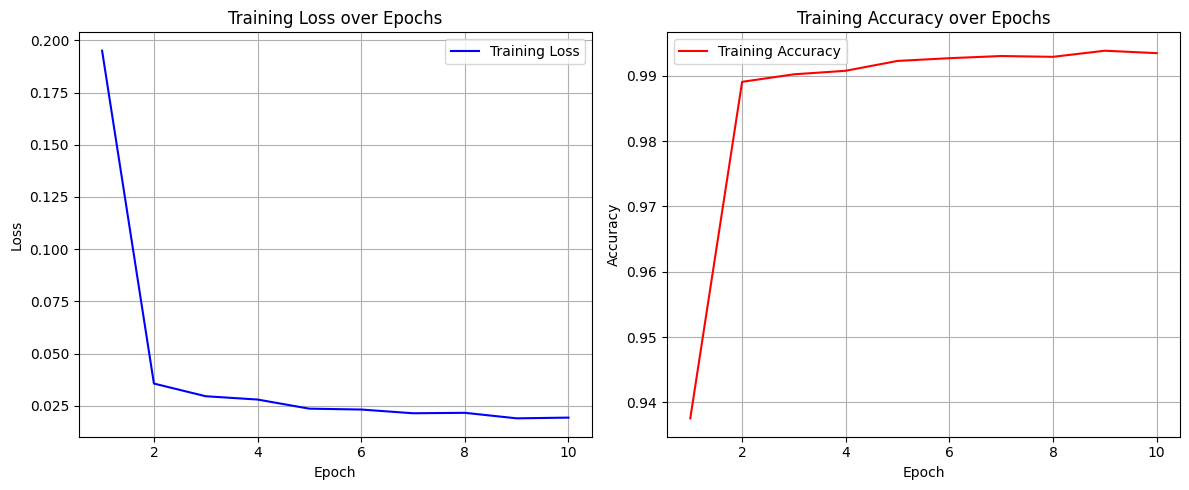

In [8]:
import matplotlib.pyplot as plt

# 1. Extract the 'loss' and 'accuracy' values from the history.history dictionary.
loss = history.history['loss']
accuracy = history.history['accuracy']

# 2. Create an array representing the epochs, ranging from 1 to the number of epochs the model was trained for.
epochs = range(1, len(loss) + 1)

# 3. Create a figure with two subplots: one for loss and one for accuracy.
plt.figure(figsize=(12, 5))

# 4. In the first subplot, plot the training loss against epochs.
plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# 5. In the second subplot, plot the training accuracy against epochs.
plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot
plt.plot(epochs, accuracy, 'r', label='Training Accuracy')
plt.title('Training Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# 6. Use plt.tight_layout() to ensure proper spacing between subplots.
plt.tight_layout()

# 7. Display the plot using plt.show().
plt.show()

## Final Task

### Subtask:
Indicate that the plots of the training history have been generated and displayed.


## Summary:

### Q&A
The plots of the training history for loss and accuracy have been successfully generated and displayed.

### Data Analysis Key Findings
*   The training loss and accuracy were extracted from the `history.history` dictionary, and an epoch range was created.
*   Two subplots were generated: one showing 'Training Loss over Epochs' and another showing 'Training Accuracy over Epochs'.
*   Both plots included appropriate labels, titles, a grid, and a legend.

### Insights or Next Steps
*   Analyzing these plots can help identify if the model is overfitting (training loss decreases while validation loss increases) or underfitting (both training loss and accuracy are stagnant or poor).


## Summarize Project Steps

### Overall Objective:
1.  **Project Goal**: The primary goal of this project is to build a deep learning model that can accurately detect the start index of a known synchronization word within a noisy signal frame.

### Data Generation and Preparation:
2.  **`generate_frame_data` Function**: This function creates synthetic signal frames (`n_total=1024` samples) containing a fixed synchronization word (`sync_word_len=64`) and random payload data. It introduces random noise with an SNR between -5dB and 5dB. The function returns the signal (real and imaginary parts as a 2-channel array) and the `start_idx` of the sync word.
3.  **`data_generator` Function**: This generator function endlessly calls `generate_frame_data` to produce `(signal, label)` pairs. The `signal` is a `(1024, 2)` float32 array. The `label` is a `(1024, 1)` float32 array where the indices corresponding to the `sync_word_len` from `start_idx` are marked with `1.0`, and all other indices are `0.0`. This essentially creates a heatmap or segmentation mask for the sync word.
4.  **`tf.data.Dataset` Creation**: A `tf.data.Dataset` is created from `data_generator` with a batch size of 32. It's configured to prefetch data for efficient training.

### Model Definition:
5.  **`create_model` Function**: The model is a U-Net like architecture built with `tf.keras.models.Sequential`.
    *   **Input Layer**: Expects signals of shape `(1024, 2)`.
    *   **Encoder**: Consists of three blocks, each with a `Conv1D` layer (kernel_size=16, relu activation, 'same' padding), `BatchNormalization`, and `MaxPooling1D` (pool_size=2, 'same' padding). This downsamples the sequence length by a factor of 8.
    *   **Decoder**: Consists of three blocks, each with a `Conv1DTranspose` layer (kernel_size=16, strides=2, relu activation, 'same' padding), followed by `BatchNormalization`. This upsamples the sequence length back to the original `1024`.
    *   **Output Layer**: A final `Conv1D` layer with `filters=1` and `kernel_size=sync_word_len` (`64`), using a `sigmoid` activation function. This layer produces a single output channel (heatmap) of shape `(1024, 1)`, indicating the probability of a sync word starting at each position.

### Model Compilation and Training:
6.  **Compilation**: The model is compiled with the `adam` optimizer, `binary_crossentropy` as the loss function (suitable for binary classification/segmentation-like output), and `accuracy` as the metric.
7.  **Training**: The model is trained using the `dataset` for `10` epochs, with `100` steps per epoch.

### Model Evaluation:
8.  **Test Data Generation**: A `test_data_generator` similar to `data_generator` is used to create an unseen `test_dataset`.
9.  **Evaluation Metrics**: The trained model is evaluated on the `test_dataset` for 50 steps, reporting `Test Loss` and `Test Accuracy`. The reported values were `Test Loss: 0.0232` and `Test Accuracy: 0.9925`.

### Visualization:
10. **Initial Signal Visualization**: An initial plot is generated to visualize a sample signal frame, showing the real and imaginary parts, and marking the actual `start_idx` and end of the sync word.
11. **Training History Plots**: Two plots are generated to visualize the training process:
    *   **Training Loss over Epochs**: Shows how the `binary_crossentropy` loss decreased over 10 epochs.
    *   **Training Accuracy over Epochs**: Shows how the `accuracy` increased over 10 epochs.

# Sync Word Detection using Deep Learning

## Project Overview
This project aims to detect the start index of a synchronization word (sync word) embedded within a noisy signal using a deep learning approach. The model learns to identify the sync word's location by outputting a heatmap-like probability distribution, indicating the likelihood of the sync word's presence at each time step.

## Data Generation
Synthetic training data is generated to simulate real-world noisy signals.
- The `generate_frame_data` function creates a signal frame of a fixed length (1024 samples) by embedding a predefined sync word (Barker Sequence) within random payload data.
- Heavy noise, with SNR ranging from -5dB to 5dB, is added to the signal.
- The `data_generator` function then formats this data for TensorFlow, creating a label that marks the sync word's duration (64 samples) with 1.0 and other parts with 0.0.
- This data is then used to construct a `tf.data.Dataset` for efficient batch processing during training.

## Model Architecture
The model employs a U-Net-like convolutional neural network (CNN) architecture designed for sequence-to-sequence prediction.
- It consists of an **encoder** pathway with `Conv1D`, `BatchNormalization`, and `MaxPooling1D` layers to progressively downsample the input signal and extract features.
- The **decoder** pathway uses `Conv1DTranspose` and `BatchNormalization` layers to upsample the features, restoring the sequence length to the original input size.
- The final layer is a `Conv1D` with a single filter and `sigmoid` activation, which outputs a probability heatmap for each time step, indicating the presence of the sync word.

## Training Process
- The model is compiled with the `adam` optimizer, `binary_crossentropy` as the loss function (suitable for binary classification at each time step), and `accuracy` as the evaluation metric.
- Training is performed using the `model.fit()` method on the generated `tf.data.Dataset`.
- For demonstration, the model was trained for 10 epochs, with 100 steps per epoch.

## Evaluation Results
The model's performance was evaluated on a separate, unseen test dataset generated similarly to the training data.
- The test dataset was also created using `tf.data.Dataset.from_generator` with a batch size of 32.
- The evaluation metrics, `Test Loss` and `Test Accuracy`, indicate how well the model generalizes to new data.
- The model achieved a `Test Loss` of 0.0232 and a `Test Accuracy` of 0.9925.

## Plots and Visualizations
- An initial plot demonstrates a sample generated signal frame, showing the real and imaginary parts of the IQ signal, with vertical lines marking the start and end of the embedded sync word.
- After training, plots are generated to visualize the model's learning progress. These plots display the **training loss over epochs** and **training accuracy over epochs**, providing insights into convergence and potential overfitting/underfitting.
